In [544]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [545]:
import geomloss
import matplotlib.pyplot as plt
import numpy as np
import ot
import pandas as pd
import scipy.stats as st
import seaborn
import torch
import math

In [546]:
from pflow.optimal_transport.transportation_plan import transport_from_potentials, transport, Transport
from pflow.optimal_transport.recentering import LearnBest

In [547]:
def systematic_resample(weights, randomState):
    N = len(weights)

    positions = (randomState.random() + np.arange(N)) / N

    indexes = np.zeros(N, dtype = int)
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes


In [548]:
def draw_uniform_within_circle(n, r, randomState):
    accepted = 0
    sample = np.zeros((n, 2), dtype = float)
    pct_accepted_in_avg = np.pi / 4.
    while accepted < n:
        nb_draw = int((n-accepted)/pct_accepted_in_avg) + 1
        proposal = randomState.uniform([-r, -r], [r, r], (nb_draw, 2))
        mask = (proposal ** 2).sum(axis=1) <= 1
        keep = proposal[mask]
        new_number = min(n, accepted + len(keep))
        sample[accepted:new_number] = keep[:new_number-accepted]
        accepted = new_number
    return sample

In [549]:
randomState = np.random.RandomState(42)
N = 500

In [550]:
seaborn.set()

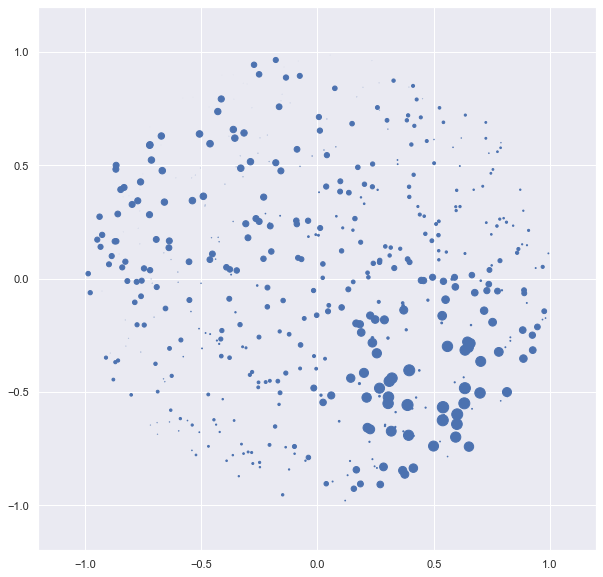

In [551]:
vals = draw_uniform_within_circle(N, 1, randomState)
vals = vals.astype(np.float32)
subPart = np.in1d(np.arange(N, dtype=int), np.random.choice(N, N//2, False))

weights_2d = np.ones(N, dtype=float)

weights_2d[subPart] = st.multivariate_normal.pdf(vals[subPart], [-0.5, 0.5], [[0.3, 0.], [0., 0.3]])
weights_2d[~subPart] = st.multivariate_normal.pdf(vals[~subPart], [0.5, -0.5], [[0.1, 0.], [0., 0.1]])
weights_2d /= weights_2d.sum()
weights_2d = weights_2d.astype(np.float32)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(vals[:, 0], vals[:, 1], s=weights_2d * 10000)
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
fig.savefig( 'originalSample.png')


In [552]:
x_test_1 = np.random.multivariate_normal([-0.5, 0.5], [[0.3, 0.], [0., 0.3]], size=300)
x_test_1 = x_test_1[(x_test_1**2).sum(axis=1)<=1.]
x_test_2 = np.random.multivariate_normal([0.5, -0.5], [[0.1, 0.], [0., 0.1]], size=300)
x_test_2 = x_test_2[(x_test_2**2).sum(axis=1)<=1.]


(-1.2, 1.2)

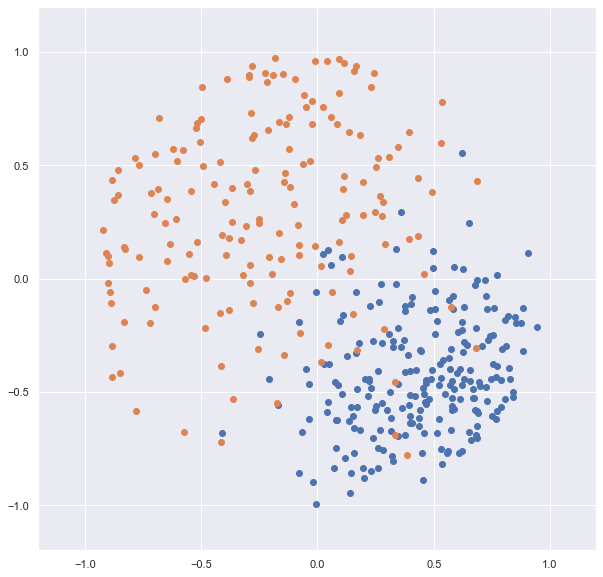

In [553]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x_test_2[:, 0], x_test_2[:, 1])
ax.scatter(x_test_1[:, 0], x_test_1[:, 1])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)

In [554]:
X_2d_torch = torch.tensor(vals)
w_2d_torch = torch.tensor(weights_2d)

In [555]:
def learn_best(loss, X, w, lr = 1., nSteps=6, savefig=True):
    import time
    # only in 2D
    x_i, x_j = X.clone(), X.clone()
    x_i.requires_grad = True
    
    # Use colors to identify the particles
    colors = (10*X[:,0]).cos() * (10*X[:,1]).cos()
    colors = colors.detach().cpu().numpy()
    
    tocs = 0.   
    nLines = math.ceil((nSteps + 1)/3)
    fig, axes = plt.subplots(ncols=3, nrows=nLines, figsize=(12,4*nLines), sharex=True, sharey=True)
    axes = iter(axes.flatten())
    ones = torch.ones_like(w, requires_grad=False) / len(w)
    cps = []
    
    ax = next(axes)
    cp = display_samples(ax, X.detach().numpy(), w.detach().numpy(), colors, with_cp=True, jitter=0.)
    ax.set_title("Original degenerate sample")
    for i in range(nSteps):
        tic = time.time()
        L_αβ = loss(ones, x_i, w, X)
        [g]  = torch.autograd.grad(L_αβ, [x_i])
        x_i.data -= lr * g * len(w)
        tocs += time.time() - tic
        ### plot
        ax = next(axes)
        cp = display_samples(ax, x_i.detach().numpy(), ones.detach().numpy(), colors, with_cp=True, jitter=0.)
        ax.set_title("t = {:1.2f}".format(lr*i + 1))
        plt.axis([-1, 1, -1, 1])
#             plt.xticks([], []); plt.yticks([], [])
        plt.tight_layout()
    
#         x_j.data.copy_(x_i.data)
        # in-place modification of the tensor's values
        
    fig.suptitle("Evolution of direct reweighting: learn X_i minimizing $OT_\epsilon(X_i, 1/n, X, w)$, elapsed time: {:.2f}s/it".format(tocs/nSteps), y=1.05)
    if savefig:
        fig.savefig('LearntReweighting.png', bbox_inches="tight")
    

In [556]:
dist_test.sample?

Signature: dist_test.sample(sample_shape=torch.Size([]))
Docstring:
Generates a sample_shape shaped sample or sample_shape shaped batch of
samples if the distribution parameters are batched.
File:      c:\programdata\anaconda3\lib\site-packages\torch\distributions\distribution.py
Type:      method


In [557]:
X_2d_test.min()

tensor(-1., grad_fn=<MinBackward1>)

In [558]:
X_2d_test.max()

tensor(1., grad_fn=<MaxBackward1>)

In [559]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights, axis=0)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights, axis=0)
    return (average, np.sqrt(variance))

In [566]:
torch.random.manual_seed(0)
sig_test = torch.tensor(2.01, requires_grad=True)
dist_test = torch.distributions.MultivariateNormal(torch.tensor([0., 0.]), scale_tril = torch.eye(2) * sig_test)
X_2d_test = dist_test.rsample([500])
test_value = transport_test.apply(X_2d_test, w_2d_torch, w_2d_torch.log())[ 0 ].std()
print(test_value)
print((test_value - test_value_1.std())*100)

tensor(2.0680, grad_fn=<StdBackward0>)
tensor(134.6783, grad_fn=<MulBackward0>)


In [567]:
def biasedTransportComparison(X, w, eps1=0.1, eps2=1., savefig=True, jitter=1e-1, reach=5.):
    from pflow.optimal_transport.transportation_plan import Transport
    from pflow.resampling.systematic import SystematicResampling
    import time
    
    transport1 = Transport(eps1, scaling=0.9, reach=reach)
    transport2 = Transport(eps2, scaling=0.9, reach=reach)
    systematic = SystematicResampling()
    
    # Use colors to identify the particles
    colors = (10*X[:,0]).cos() * (10*X[:,1]).cos()
    colors = colors.detach().cpu().numpy()
    
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), sharex=True, sharey=True)
    
    cps = []
    tic = time.time()
    transported_x_1, transported_w_1 = transport1.apply(X, w, w.log())
    transported_w_1 = transported_w_1.exp()
    toc = time.time()
    
    transported_x_2, transported_w_2 = transport2.apply(X, w, w.log())
    transported_w_2 = transported_w_2.exp()
    
    resampled_x, resampled_w = systematic.apply(X, w, w.log())
    resampled_w = resampled_w.exp()
    
    cp_original = display_samples(axes[0, 0], X.detach().cpu().numpy(), w.detach().cpu().numpy(), colors, with_cp=True, jitter=0.)
    axes[0, 0].set_title("Original degenerate sample")

    cp_systematic = display_samples(axes[0, 1], resampled_x.detach().cpu().numpy() + np.random.normal(0., jitter, resampled_x.shape), resampled_w.detach().cpu().numpy(), colors, with_cp=True, jitter=jitter)
    axes[0, 1].set_title("Systematic resample")
    
    cp_transported1 = display_samples(axes[1, 0], transported_x_1.detach().cpu().numpy(), transported_w_1.detach().cpu().numpy(), colors, with_cp=True, jitter=0.)
    axes[1, 0].set_title("Transported reweighting, eps = {}".format(eps1))
    
    cp_transported2 = display_samples(axes[1, 1], transported_x_2.detach().cpu().numpy(), transported_w_2.detach().cpu().numpy(), colors, with_cp=True, jitter=0.)
    axes[1, 1].set_title("Transported reweighting, eps = {}".format(eps2))
    
    
    plt.axis([-1, 1, -1, 1])
    plt.tight_layout()

    plt.suptitle("Comparison of reweighting schemes, elapsed time: {:.2f}s".format((toc-tic)), y=1.05)
    if savefig:
        fig.savefig('BiasedTransport.png', bbox_inches="tight")
    

In [568]:
def display_samples(ax, x, w, color, with_cp, jitter) :
    import seaborn as sns
    x_ = x + np.random.normal(0., jitter, x.shape)
    ax.scatter( x_[:,0], x_[:,1], 5000*w, color, edgecolors='none', alpha= 1. )
    mesh_vals = np.linspace(-1., 1., 50)
    mesh = np.meshgrid(mesh_vals, mesh_vals)
    kde = st.kde.gaussian_kde(x_.T, weights = w)
    mesh_vals = np.stack([mesh[0], mesh[1]], axis=0).reshape(2, -1)
    kde_val = kde(mesh_vals).reshape(*mesh[0].shape)

#     kde_vals = [kde(mesh_x, mesh_y)]
    if with_cp:
        cp = ax.contourf(mesh[0], mesh[1], kde_val, alpha=0.3)
        return cp

    

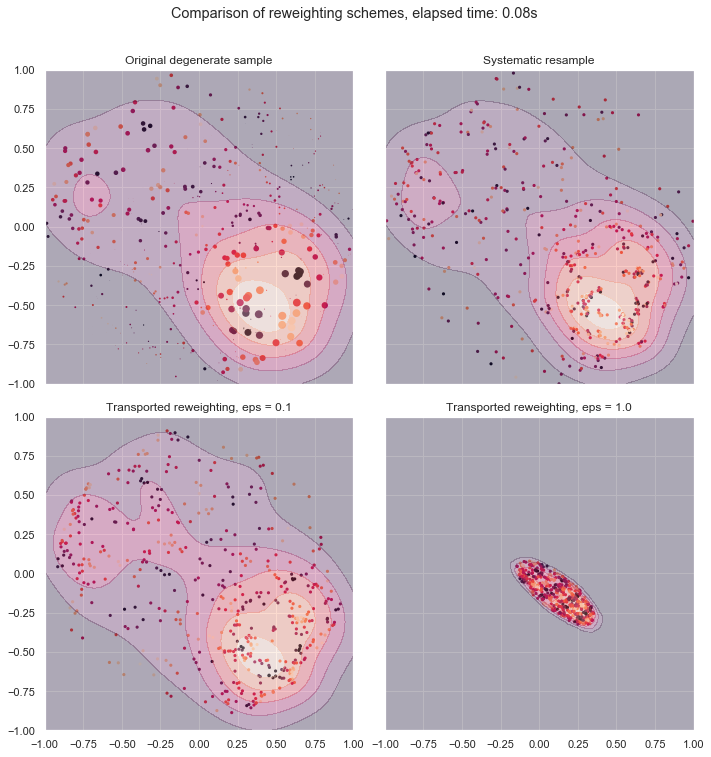

In [569]:
biasedTransportComparison(X_2d_torch, w_2d_torch, 0.1, 1., jitter=0.01, reach=2.5)

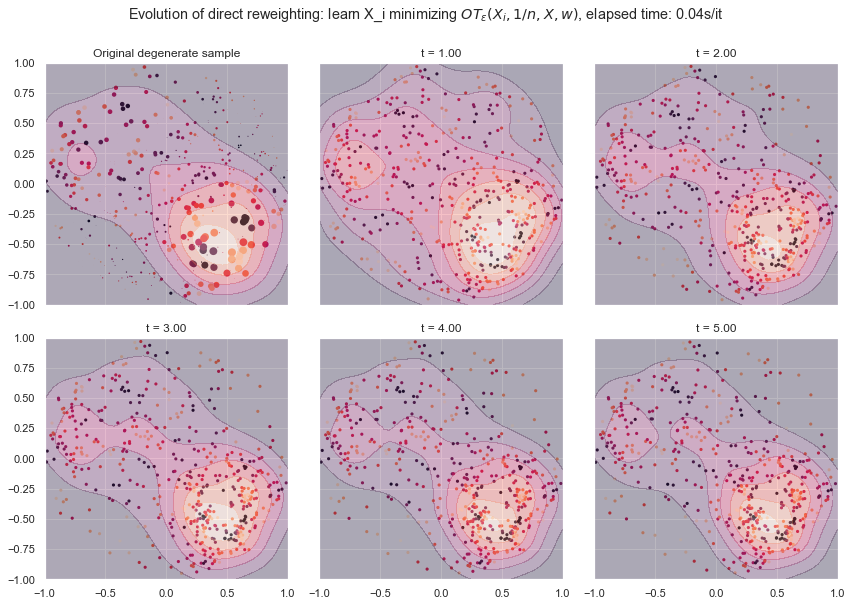

In [570]:
unbiasedLoss = geomloss.SamplesLoss(reach=None, potentials=False, debias=True, scaling=0.5, blur=0.1)
learn_best(unbiasedLoss, X_2d_torch, w_2d_torch, 1., nSteps=5)